In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local") \
    .appName("AppName") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/06 19:08:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df = spark.read.option('escape','"').csv('ks-projects-201801.csv', header=True, inferSchema=True, mode="DROPMALFORMED")

### Most frequent words in project title analysis

In [4]:
pip install wordcloud

  Using cached wordcloud-1.9.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (455 kB)
Note: you may need to restart the kernel to use updated packages.


In [5]:
#library used for project title analysis
from pyspark.sql.functions import col, explode, trim, lower, regexp_replace
from pyspark.ml.feature import Tokenizer, StopWordsRemover
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import re
stopwords = set(STOPWORDS)

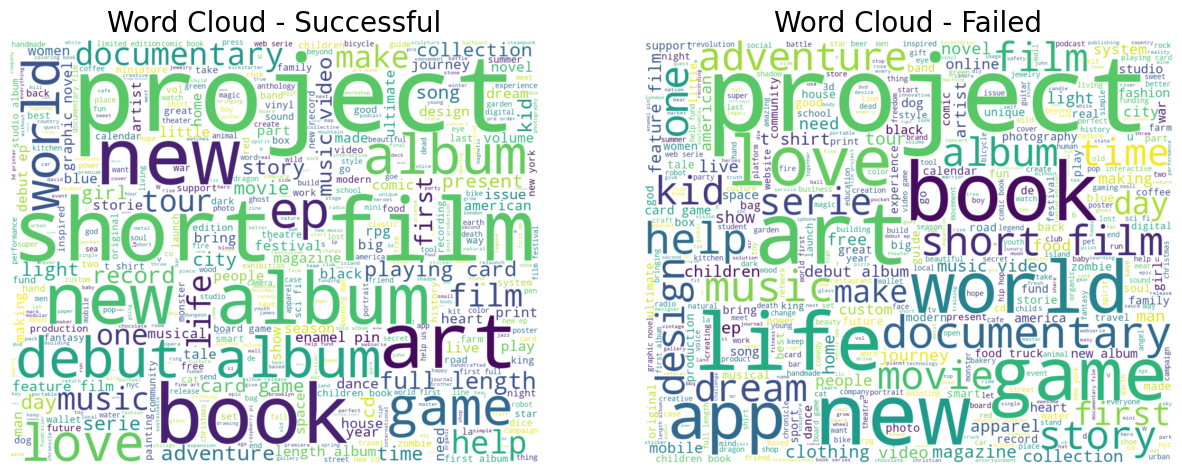

In [4]:
df_tmp = df.select("name", "state")

df_tmp = df_tmp.filter(df["name"].isNotNull())

# Filter for successful and failed states
df_successful = df_tmp.filter(col("state") == "successful")
df_failed = df_tmp.filter(col("state") == "failed")

tokenizer = Tokenizer(inputCol="name", outputCol="words")
# Remove stop words (the, and, in...)
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

df_successful_words = remover.transform(tokenizer.transform(df_successful)).select("filtered_words")
df_failed_words = remover.transform(tokenizer.transform(df_failed)).select("filtered_words")

#Explode the arrays of words into separate rows (each element of the array "filtered_words" becomes 
#    a separate rows in the new df) under the new column name "word"
df_successful_words = df_successful_words.select(explode("filtered_words").alias("word"))
df_failed_words = df_failed_words.select(explode("filtered_words").alias("word"))

# Combine the words into a single string (for WordCloud usage)
successful_text = " ".join(df_successful_words.rdd.map(lambda x: x.word).collect())
failed_text = " ".join(df_failed_words.rdd.map(lambda x: x.word).collect())

#WordCloud for successful state
wordcloud_successful = WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words=500,
    max_font_size=200, 
    width=1000, height=800,
    random_state=42,
).generate(successful_text)

#WordCloud for failed state
wordcloud_failed = WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words=500,
    max_font_size=200, 
    width=1000, height=800,
    random_state=42,
).generate(failed_text)


fig, axes = plt.subplots(1, 2, figsize=(15, 8))

axes[0].imshow(wordcloud_successful, interpolation='bilinear')
axes[0].set_title("Word Cloud - Successful", fontsize=20)
axes[0].axis('off')

axes[1].imshow(wordcloud_failed, interpolation='bilinear')
axes[1].set_title("Word Cloud - Failed", fontsize=20)
axes[1].axis('off')

plt.show()

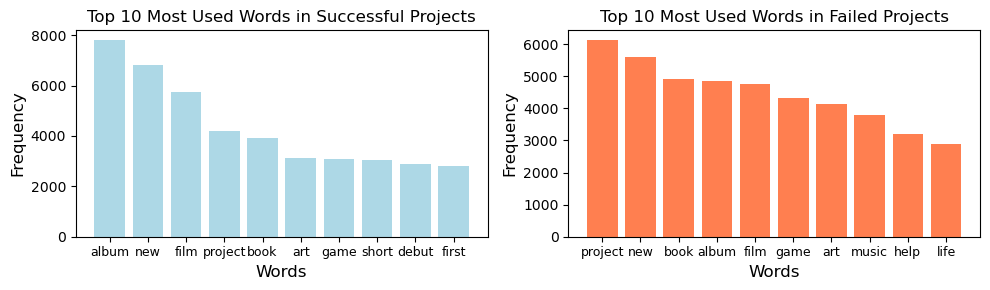

In [16]:
n=10  #top n words used

df_tmp = df.select("name", "state")

df_tmp = df_tmp.filter(df_tmp["name"].isNotNull())

#Remove special characters and empty strings
df_tmp = df_tmp.withColumn("name", (lower(regexp_replace(col("name"), '[^a-zA-Z\s]', ''))).alias("name"))

# Tokenize the 'name' column
tokenizer = Tokenizer(inputCol="name", outputCol="words")

#Remove stop words (like the, and, in...)
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

#Apply transformations
df_filtered_words = remover.transform(tokenizer.transform(df_tmp)).select("filtered_words", "state")

#Explode the arrays of words into separate rows (each element of the array "filtered_words" becomes 
#    a separate rows in the new df) under the new column name "word"
df_exploded_words = df_filtered_words.select("state", explode("filtered_words").alias("word"))

#Filter successful and failed states
df_successful_words = df_exploded_words.filter((col("state") == "successful") & (trim(col("word")) != ""))
df_failed_words = df_exploded_words.filter((col("state") == "failed") & (trim(col("word")) != ""))

#Remove null
df_successful_words = df_successful_words.filter(df_successful_words["word"].isNotNull())
df_failed_words = df_failed_words.filter(df_failed_words["word"].isNotNull())

#Calculate the frequency of each word
successful_word_counts = df_successful_words.groupBy("word").count().orderBy(col("count").desc()).limit(n)
failed_word_counts = df_failed_words.groupBy("word").count().orderBy(col("count").desc()).limit(n)

#Convert Spark DataFrames to Pandas DataFrames (only for plotting)
successful_word_counts_pd = successful_word_counts.toPandas()
failed_word_counts_pd = failed_word_counts.toPandas()


fig, axes = plt.subplots(1, 2, figsize=(10, 3))

#Successful
axes[0].bar(successful_word_counts_pd["word"], successful_word_counts_pd["count"], color='lightblue')
axes[0].set_title(f'Top {n} Most Used Words in Successful Projects', fontsize=12)
axes[0].set_xlabel('Words', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].tick_params(axis='x', labelsize=9)

#Failed
axes[1].bar(failed_word_counts_pd["word"], failed_word_counts_pd["count"], color='coral')
axes[1].set_title(f'Top {n} Most Used Words in Failed Projects', fontsize=12)
axes[1].set_xlabel('Words', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].tick_params(axis='x', labelsize=9)

plt.tight_layout()
plt.show()